<a href="https://colab.research.google.com/github/omr-ql/NLP_Social-Media-Sentiment/blob/main/Complete_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyLDAvis imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 21.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import joblib

# NLTK
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

# Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC # Added LinearSVC
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, silhouette_score, silhouette_samples
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD, PCA, NMF, LatentDirichletAllocation
from sklearn.cluster import KMeans

# Imblearn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImpbPipeline

# Topic Modeling Visualization
import pyLDAvis
import pyLDAvis.gensim_models
import gensim
from gensim.corpora import Dictionary

# Download NLTK resources
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True) # Added explicit download

# Configuration
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Define column names
column_names = ['tweet_id', 'entity', 'sentiment', 'tweet_content']

# Load data (Assuming files are in the root directory)
try:
    df_train = pd.read_csv('twitter_training.csv', names=column_names)
    df_val = pd.read_csv('twitter_validation.csv', names=column_names)
    print("Files loaded successfully.")
except FileNotFoundError:
    print("Error: Files not found. Please upload 'twitter_training.csv' and 'twitter_validation.csv' to the Colab files area.")

print("Training Data Shape:", df_train.shape)
print("Validation Data Shape:", df_val.shape)

# Drop missing values immediately
df_train.dropna(subset=['tweet_content'], inplace=True)
df_train.drop_duplicates(subset=['tweet_content'], inplace=True)
print(f"Training rows after cleaning missing/duplicates: {len(df_train)}")

Files loaded successfully.
Training Data Shape: (74682, 4)
Validation Data Shape: (1000, 4)
Training rows after cleaning missing/duplicates: 69491


In [ ]:
# Initialize tools
tokenizer = TweetTokenizer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'): return wordnet.ADJ
    elif treebank_tag.startswith('V'): return wordnet.VERB
    elif treebank_tag.startswith('N'): return wordnet.NOUN
    elif treebank_tag.startswith('R'): return wordnet.ADV
    else: return wordnet.NOUN

def clean_text(text):
    if pd.isna(text): return ""
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+', '', text)  # remove mentions
    text = re.sub(r'#\w+', '', text)  # remove hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # keep only letters
    return ' '.join(text.split())

def extract_hashtags_mentions(text):
    if pd.isna(text): return [], []
    hashtags = re.findall(r"#(\w+)", text)
    mentions = re.findall(r"@(\w+)", text)
    return hashtags, mentions

def preprocess_tweet(text):
    # Extract metadata before cleaning
    hashtags, mentions = extract_hashtags_mentions(text)

    # Clean
    cleaned = clean_text(text)
    if not cleaned.strip():
        return "", hashtags, mentions

    # Tokenize and Lemmatize
    tokens = tokenizer.tokenize(cleaned.lower())
    pos_tags = pos_tag(tokens)
    lemmatized = []
    for word, tag in pos_tags:
        if word not in stop_words and len(word) > 2:
            wn_tags = get_wordnet_pos(tag)
            lemma = lemmatizer.lemmatize(word, wn_tags)
            lemmatized.append(lemma)

    return ' '.join(lemmatized), hashtags, mentions

In [ ]:
print("Preprocessing Training Set...")
# Apply preprocessing
processed_train = df_train['tweet_content'].apply(preprocess_tweet)
df_train['clean_text'] = processed_train.apply(lambda x: x[0])
df_train['hashtags'] = processed_train.apply(lambda x: x[1])
df_train['mentions'] = processed_train.apply(lambda x: x[2])

print("Preprocessing Validation Set...")
processed_val = df_val['tweet_content'].apply(preprocess_tweet)
df_val['clean_text'] = processed_val.apply(lambda x: x[0])

# Remove empty rows after cleaning
df_train = df_train[df_train['clean_text'].str.len() > 0].reset_index(drop=True)
df_val = df_val[df_val['clean_text'].str.len() > 0].reset_index(drop=True)

print(f"Final Training Size: {len(df_train)}")

Preprocessing Training Set...
Preprocessing Validation Set...
Final Training Size: 69024


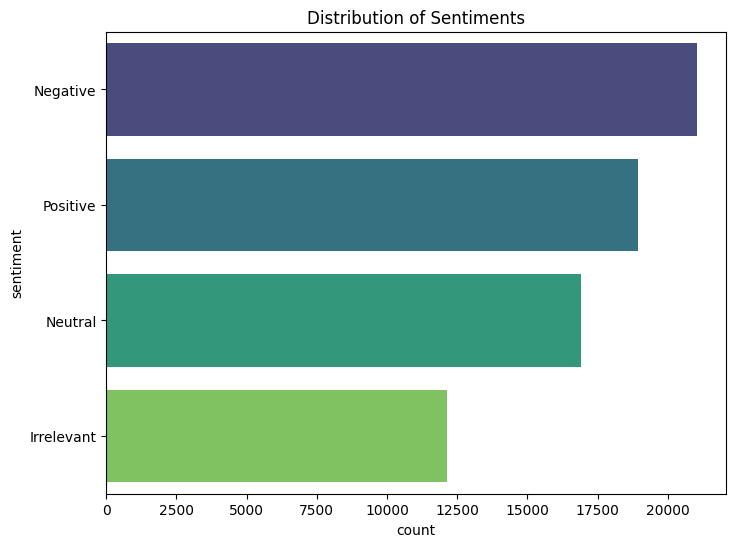

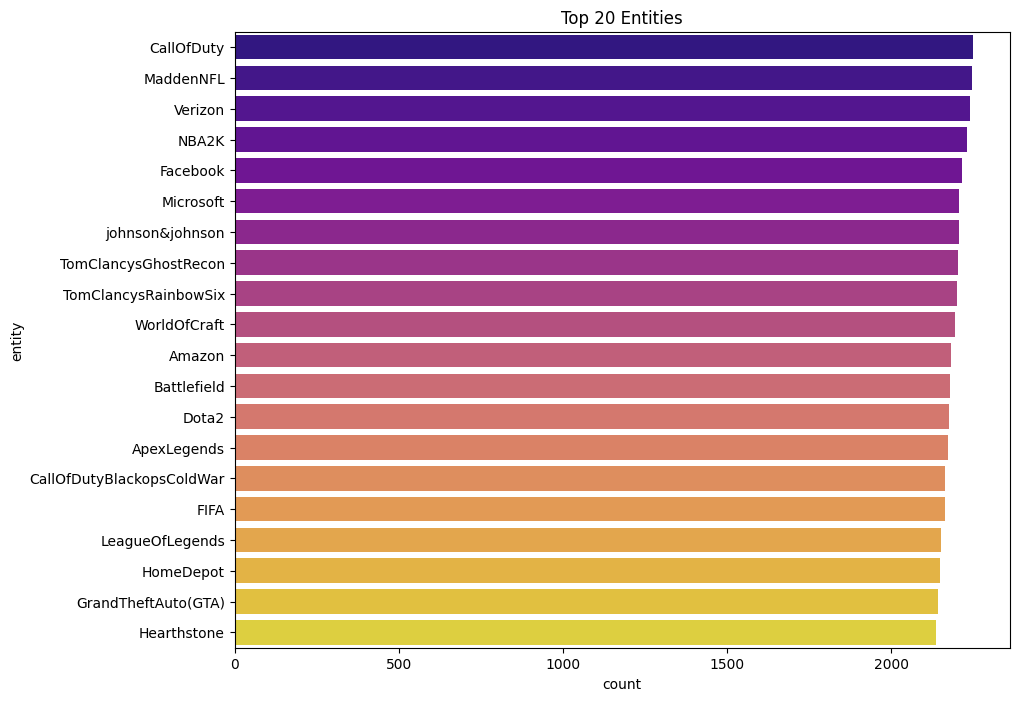

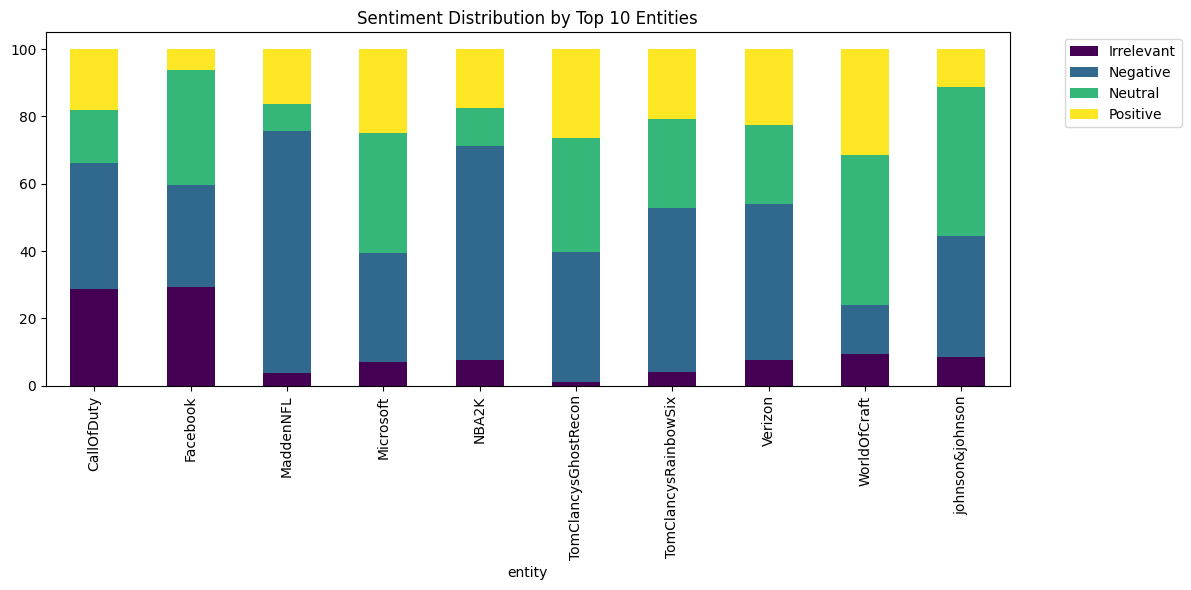

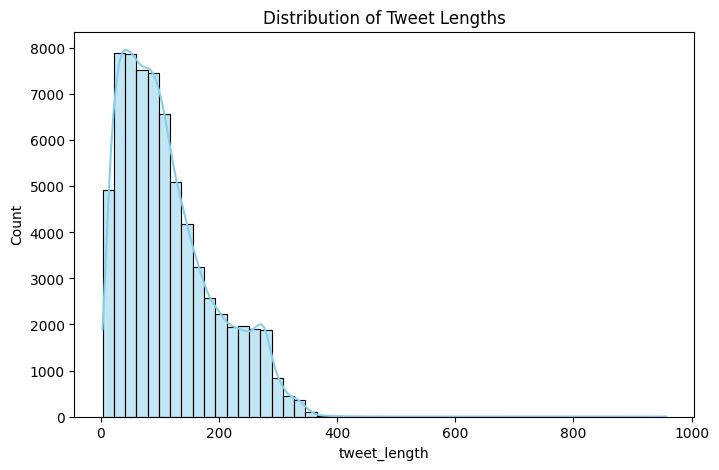

In [ ]:
# 1. Sentiment Distribution
plt.figure(figsize=(8, 6))
sns.countplot(y='sentiment', data=df_train, order=df_train['sentiment'].value_counts().index, palette='viridis')
plt.title('Distribution of Sentiments')
plt.show()

# 2. Top Entities
plt.figure(figsize=(10, 8))
top_entities = df_train['entity'].value_counts().head(20).index
sns.countplot(y='entity', data=df_train, order=top_entities, palette='plasma')
plt.title('Top 20 Entities')
plt.show()

# 3. Sentiment by Top 10 Entities
top_10_entities = df_train['entity'].value_counts().head(10).index
df_top_10 = df_train[df_train['entity'].isin(top_10_entities)]
sentiment_by_entity = pd.crosstab(df_top_10['entity'], df_top_10['sentiment'], normalize='index') * 100

sentiment_by_entity.plot(kind='bar', stacked=True, colormap='viridis', figsize=(12, 6))
plt.title('Sentiment Distribution by Top 10 Entities')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 4. Tweet Length Analysis
df_train['tweet_length'] = df_train['tweet_content'].apply(len)
plt.figure(figsize=(8, 5))
sns.histplot(df_train['tweet_length'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Tweet Lengths')
plt.show()

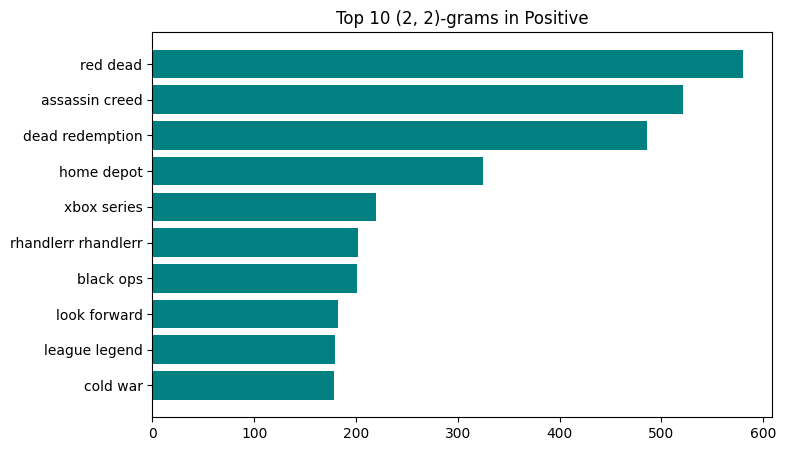

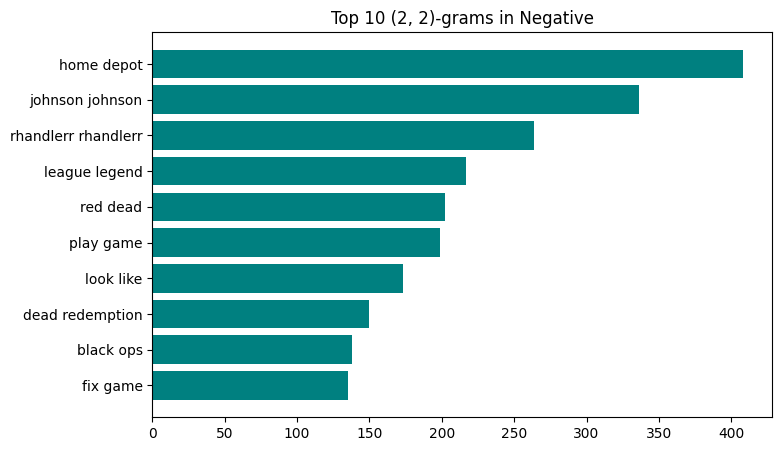

In [ ]:
def plot_top_ngrams(sentiment_class, ngram_range=(1,1), top_k=10):
    texts = df_train[df_train['sentiment'] == sentiment_class]['clean_text']
    if texts.empty: return

    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english', min_df=5, max_features=10000)
    X_counts = vec.fit_transform(texts)
    freqs = np.array(X_counts.sum(axis=0)).flatten()
    ngrams = vec.get_feature_names_out()
    top_idx = freqs.argsort()[-top_k:][::-1]

    plt.figure(figsize=(8, 5))
    plt.barh(range(len(top_idx)), freqs[top_idx], color='teal')
    plt.yticks(range(len(top_idx)), [ngrams[i] for i in top_idx])
    plt.gca().invert_yaxis()
    plt.title(f'Top {top_k} {ngram_range}-grams in {sentiment_class}')
    plt.show()

# Plot bigrams for Positive and Negative
plot_top_ngrams('Positive', ngram_range=(2,2))
plot_top_ngrams('Negative', ngram_range=(2,2))

In [ ]:
# Data preparation (remains the same)
X_train = df_train["clean_text"]
y_train = df_train["sentiment"]
X_val = df_val['clean_text']
y_val = df_val['sentiment']

# Initialize and fit TF-IDF Vectorizer once
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=10000) # Using broadest ngram_range
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

# Pipelines (TF-IDF step removed, LinearSVC used)
pipelines = {
    'Logistic Regression': Pipeline([
        ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
    ]),
    'Random Forest': Pipeline([
        ('clf', RandomForestClassifier(n_estimators=50, class_weight='balanced', n_jobs=-1))
    ]),
    'SVM': Pipeline([
        ('clf', LinearSVC(class_weight='balanced', max_iter=1000)) # Changed to LinearSVC
    ])
}

# Evaluation
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
results = {}

print("Evaluating models (CV)...")
for name, pipe in pipelines.items():
    scores = cross_val_score(pipe, X_train_tfidf, y_train, cv=skf, scoring='accuracy', n_jobs=-1) # Use X_train_tfidf
    results[name] = scores.mean()
    print(f"{name}: {scores.mean():.4f}")

# Train Best Model
best_name = max(results, key=results.get)
best_model = pipelines[best_name]
print(f"\nTraining Best Model: {best_name}")
best_model.fit(X_train_tfidf, y_train) # Use X_train_tfidf

# Validation
y_pred = best_model.predict(X_val_tfidf) # Use X_val_tfidf for prediction
print(f"Validation Accuracy: {accuracy_score(y_val, y_pred):.4f}")
print(classification_report(y_val, y_pred))

# Save
joblib.dump(best_model, 'best_sentiment_classifier.pkl')
print("Model saved.")

Evaluating models (CV)...
Logistic Regression: 0.7211
Random Forest: 0.8719
SVM: 0.7700

Training Best Model: Random Forest
Validation Accuracy: 0.9560
              precision    recall  f1-score   support

  Irrelevant       0.93      0.97      0.95       172
    Negative       0.96      0.97      0.96       265
     Neutral       0.97      0.93      0.95       285
    Positive       0.96      0.97      0.96       277

    accuracy                           0.96       999
   macro avg       0.95      0.96      0.96       999
weighted avg       0.96      0.96      0.96       999

Model saved.


In [ ]:
# Use only Positive/Negative for clustering analysis
train_filtered = df_train[df_train["sentiment"].isin(["Positive", "Negative"])].copy()
print("Filtered shape for Unsupervised:", train_filtered.shape)

# TF-IDF
vectorizer_unsup = TfidfVectorizer(max_df=0.95, min_df=3, max_features=15000, ngram_range=(1, 3), stop_words="english")
X_tfidf = vectorizer_unsup.fit_transform(train_filtered["clean_text"])

# Dimensionality Reduction (SVD) for Clustering
svd = TruncatedSVD(n_components=100, random_state=42)
X_reduced = svd.fit_transform(X_tfidf)
print("Data reduced to 100 components.")

Filtered shape for Unsupervised: (39958, 8)
Data reduced to 100 components.


Running K-Means for different k values...


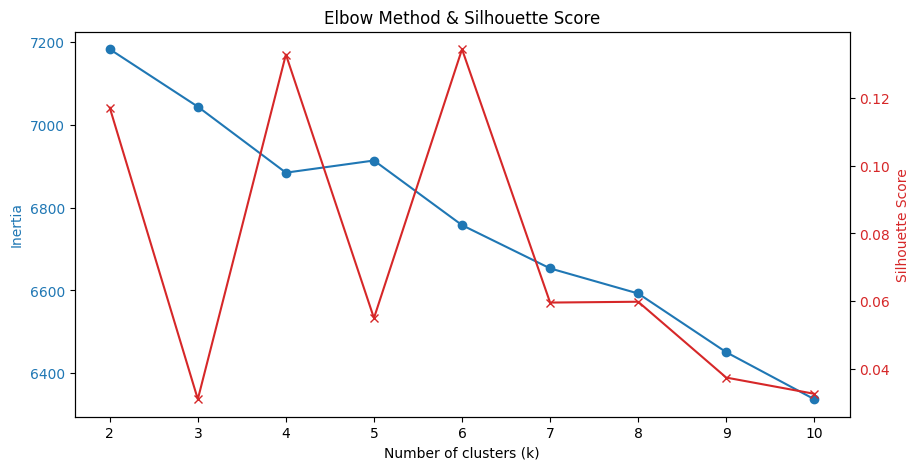

Optimal K based on Silhouette: 6


In [ ]:
# Elbow Method and Silhouette Analysis
k_values = range(2, 11)
inertia_scores = []
sil_scores = []

print("Running K-Means for different k values...")
for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_reduced)
    inertia_scores.append(km.inertia_)

    # Calculate Silhouette (on a sample for speed if dataset is huge)
    if k <= 10:
        labels = km.labels_
        sil_scores.append(silhouette_score(X_reduced, labels))

# Plot Elbow and Silhouette
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Inertia', color='tab:blue')
ax1.plot(k_values, inertia_scores, marker='o', color='tab:blue', label='Inertia')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Silhouette Score', color='tab:red')
ax2.plot(k_values, sil_scores, marker='x', color='tab:red', label='Silhouette')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Elbow Method & Silhouette Score')
plt.show()

# Select Best K (Highest Silhouette)
best_k = k_values[np.argmax(sil_scores)]
print(f"Optimal K based on Silhouette: {best_k}")

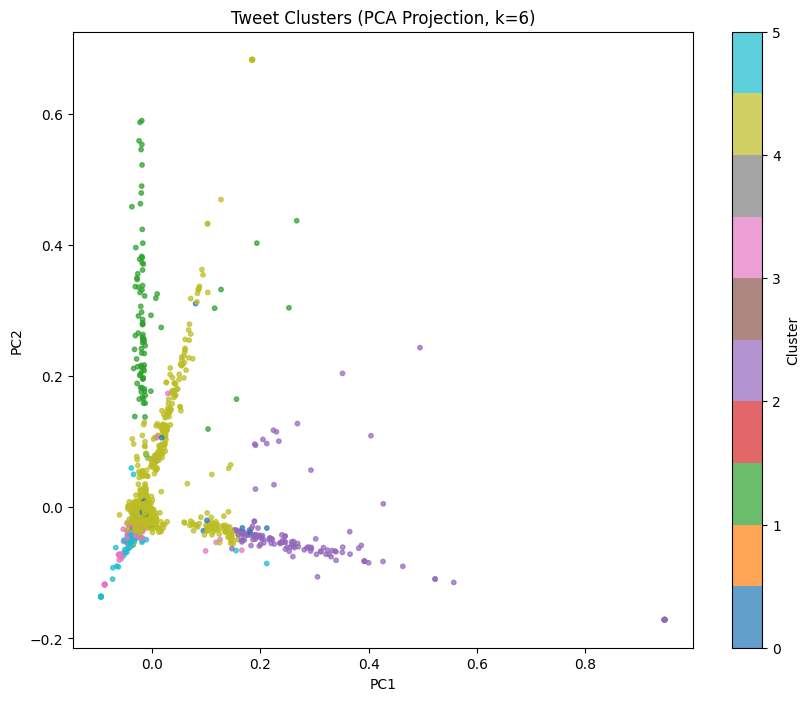


Cluster vs Sentiment Distribution:
sentiment  Negative  Positive
cluster                      
0               146       783
1               219       573
2              1084       278
3               592      1408
4             18863     14859
5               127      1026


In [ ]:
# Fit Final K-Means
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=30)
clusters = kmeans_final.fit_predict(X_reduced)
train_filtered['cluster'] = clusters

# PCA for 2D Visualization
pca = PCA(n_components=2, random_state=42)
# Sample for plotting if data is too large (max 4000 pts)
sample_idx = np.random.choice(X_reduced.shape[0], min(4000, X_reduced.shape[0]), replace=False)
X_pca = pca.fit_transform(X_reduced[sample_idx])
labels_sample = clusters[sample_idx]

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_sample, cmap='tab10', s=10, alpha=0.7)
plt.title(f'Tweet Clusters (PCA Projection, k={best_k})')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(scatter, label='Cluster')
plt.show()

# Cluster vs Sentiment Cross-tab
print("\nCluster vs Sentiment Distribution:")
print(pd.crosstab(train_filtered['cluster'], train_filtered['sentiment']))

In [ ]:
# NMF (Non-Negative Matrix Factorization)
n_topics = 10
nmf_model = NMF(n_components=n_topics, random_state=42, init="nndsvd")
W_nmf = nmf_model.fit_transform(X_tfidf)
feature_names = np.array(vectorizer_unsup.get_feature_names_out())

print("--- NMF Topics ---")
for topic_idx, topic in enumerate(nmf_model.components_):
    top_indices = topic.argsort()[::-1][:10]
    print(f"Topic {topic_idx}: {', '.join(feature_names[top_indices])}")

# LDA (Latent Dirichlet Allocation) - Sklearn
count_vec = CountVectorizer(max_df=0.95, min_df=5, max_features=10000, stop_words='english')
X_count = count_vec.fit_transform(train_filtered["clean_text"])

lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42, learning_method="batch")
lda_model.fit(X_count)

print("\n--- LDA Topics ---")
terms = count_vec.get_feature_names_out()
for topic_idx, topic in enumerate(lda_model.components_):
    top_indices = topic.argsort()[::-1][:10]
    print(f"Topic {topic_idx}: {', '.join(terms[top_indices])}")

--- NMF Topics ---
Topic 0: play, like, really, time, look, bad, new, fun, make, dont
Topic 1: fuck, fuck fuck, let fuck, let, fucking, dont fuck, fuck game, fuck shit, holy fuck, yall
Topic 2: love, love game, love new, new, love play, really love, warcraft, love love, creed, love pubg
Topic 3: dead, red, red dead, redemption, dead redemption, red dead redemption, play red, play red dead, masterpiece, finish
Topic 4: shit, holy, holy shit, gta, fix, wtf, dog, fuck shit, hate, dog shit
Topic 5: good, look, good game, look good, feel good, news, good news, really good, feel, wow
Topic 6: home, depot, home depot, thank, work, happy, miss, unk, lowes, walmart
Topic 7: rhandlerr, rhandlerr rhandlerr, rhandlerr rhandlerr rhandlerr, nice, thank, wtf, fix, thanks, ban, nice rhandlerr
Topic 8: game, best, fix, wtf, best game, play game, video, server, video game, year
Topic 9: wait, xbox, wait play, come, series, wait game, xbox series, amazing, creed, assassin

--- LDA Topics ---
Topic 0: ver

In [ ]:
# Prepare data for Gensim
tokenized_docs = [doc.split() for doc in train_filtered["clean_text"]]
dictionary = Dictionary(tokenized_docs)
corpus = [dictionary.doc2bow(text) for text in tokenized_docs]

n_topics_new = 15
gensim_lda_new = gensim.models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=n_topics_new,
    random_state=42,
    passes=5
)

print(f"Retrained Gensim LDA model with {n_topics_new} topics.")

# Visualize the new LDA model
vis_new = pyLDAvis.gensim_models.prepare(gensim_lda_new, corpus, dictionary)
pyLDAvis.display(vis_new)

Retrained Gensim LDA model with 15 topics.


In [ ]:
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from torch.optim import AdamW # Corrected import path for AdamW
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report

# Map sentiment labels to numerical values
sentiment_to_int = {'Positive': 0, 'Negative': 1, 'Neutral': 2, 'Irrelevant': 3}
df_train['sentiment_label'] = df_train['sentiment'].map(sentiment_to_int)
df_val['sentiment_label'] = df_val['sentiment'].map(sentiment_to_int)

print("Libraries imported and sentiment labels mapped.")

Libraries imported and sentiment labels mapped.


In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Tokenize training data
encodings_train = tokenizer(list(df_train['clean_text'].values), truncation=True, padding='max_length', return_tensors='pt', max_length=128)

# Tokenize validation data
encodings_val = tokenizer(list(df_val['clean_text'].values), truncation=True, padding='max_length', return_tensors='pt', max_length=128)

print("DistilBERT tokenizer initialized and text data tokenized.")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

DistilBERT tokenizer initialized and text data tokenized.


In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create Dataset instances
train_dataset = SentimentDataset(encodings_train, df_train['sentiment_label'].tolist())
val_dataset = SentimentDataset(encodings_val, df_val['sentiment_label'].tolist())

print("Custom PyTorch Dataset classes created for training and validation.")

Custom PyTorch Dataset classes created for training and validation.


In [ ]:
batch_size = 16 # Define a batch size

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print(f"DataLoader objects created with a batch size of {batch_size}.")

DataLoader objects created with a batch size of 16.


In [ ]:
num_labels = len(sentiment_to_int)
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

model.gradient_checkpointing_enable()

optimizer = AdamW(model.parameters(), lr=5e-5)

print(f"DistilBERT model initialized with {num_labels} labels, moved to {device}.")
print(f"AdamW optimizer configured with learning rate 5e-5.")
print("Cross-entropy loss function is implicitly used by DistilBertForSequenceClassification.")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBERT model initialized with 4 labels, moved to cuda.
AdamW optimizer configured with learning rate 5e-5.
Cross-entropy loss function is implicitly used by DistilBertForSequenceClassification.


In [ ]:
epochs = 3

# Training Loop
print("Starting training...")
model.train()
for epoch in range(epochs):
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Average Loss: {total_loss/len(train_loader):.4f}")

print("Training complete.")

# Evaluation Loop
print("Starting evaluation...")
model.eval()
val_true_labels = []
val_predictions = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        val_true_labels.extend(labels.cpu().numpy())
        val_predictions.extend(predictions.cpu().numpy())

accuracy = accuracy_score(val_true_labels, val_predictions)
print(f"\nValidation Accuracy: {accuracy:.4f}")

# Convert numerical labels back to original sentiment names for report
int_to_sentiment = {v: k for k, v in sentiment_to_int.items()}
predicted_sentiment_names = [int_to_sentiment[p] for p in val_predictions]
true_sentiment_names = [int_to_sentiment[t] for t in val_true_labels]

print("\nClassification Report:")
print(classification_report(true_sentiment_names, predicted_sentiment_names))

# Optionally save the fine-tuned model
torch.save(model.state_dict(), 'distilbert_sentiment_classifier.pt')
print("Fine-tuned DistilBERT model saved to 'distilbert_sentiment_classifier.pt'.")

Starting training...
Epoch 1/3, Average Loss: 0.8136
Epoch 2/3, Average Loss: 0.2979
Epoch 3/3, Average Loss: 0.1545
Training complete.
Starting evaluation...

Validation Accuracy: 0.9650

Classification Report:
              precision    recall  f1-score   support

  Irrelevant       0.93      0.97      0.95       172
    Negative       0.98      0.98      0.98       265
     Neutral       0.98      0.96      0.97       285
    Positive       0.96      0.95      0.96       277

    accuracy                           0.96       999
   macro avg       0.96      0.97      0.96       999
weighted avg       0.97      0.96      0.97       999

Fine-tuned DistilBERT model saved to 'distilbert_sentiment_classifier.pt'.


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# 2. Initialize a Tokenizer object and fit it on the clean_text column
max_words = 10000 # Define vocabulary size
tokenizer_lstm = Tokenizer(num_words=max_words, oov_token='<unk>')
tokenizer_lstm.fit_on_texts(df_train['clean_text'])

print(f"Tokenizer fitted with {len(tokenizer_lstm.word_index)} unique words.")

# 3. Convert the clean_text column from both df_train and df_val into sequences
X_train_sequences = tokenizer_lstm.texts_to_sequences(df_train['clean_text'])
X_val_sequences = tokenizer_lstm.texts_to_sequences(df_val['clean_text'])

print("Text data converted to sequences.")


Tokenizer fitted with 33211 unique words.
Text data converted to sequences.


In [ ]:
max_sequence_length = max(len(x) for x in X_train_sequences)

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length)
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_sequence_length)

print(f"Maximum sequence length: {max_sequence_length}")
print("Training and validation sequences padded.")

Maximum sequence length: 129
Training and validation sequences padded.


In [ ]:
embedding_dim = 128 # Chosen embedding dimension

model_lstm = Sequential([
    Embedding(input_dim=len(tokenizer_lstm.word_index) + 1, # Vocabulary size + 1 for padding
              output_dim=embedding_dim,
              input_length=max_sequence_length),
    LSTM(units=128),
    Dense(units=num_labels, activation='softmax')
])

LSTM model architecture defined.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("LSTM model compiled.")

LSTM model compiled.


In [ ]:
print("LSTM model architecture defined.")
model_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (32, 129, 128)         │     4,251,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (32, 128)              │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 4)                │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,149,710 (50.16 MB)

 Trainable params: 4,383,236 (16.72 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,766,474 (33.44 MB)

In [ ]:
epochs = 5
batch_size = 32

print(f"Starting LSTM model training for {epochs} epochs with batch size {batch_size}...")
history = model_lstm.fit(
    X_train_padded,
    df_train['sentiment_label'],
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val_padded, df_val['sentiment_label'])
)

print("LSTM model training complete.")

Starting LSTM model training for 5 epochs with batch size 32...
Epoch 1/5
2157/2157 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.9456 - loss: 0.1532 - val_accuracy: 0.9479 - val_loss: 0.2153
Epoch 2/5
2157/2157 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - accuracy: 0.9562 - loss: 0.1199 - val_accuracy: 0.9550 - val_loss: 0.2331
Epoch 3/5
2157/2157 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.9639 - loss: 0.0995 - val_accuracy: 0.9550 - val_loss: 0.2310
Epoch 4/5
2157/2157 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.9686 - loss: 0.0847 - val_accuracy: 0.9530 - val_loss: 0.2415
Epoch 5/5
2157/2157 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.9744 - loss: 0.0695 - val_accuracy: 0.9489 - val_loss: 0.2434
LSTM model training complete.


In [ ]:
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, concatenate
from tensorflow.keras.models import Model

# Define the input layer
input_layer = Input(shape=(max_sequence_length,))

# Create the embedding layer
embedding_layer = Embedding(input_dim=len(tokenizer_lstm.word_index) + 1,
                            output_dim=128,
                            input_length=max_sequence_length)(input_layer)

# Define filter sizes
filter_sizes = [3, 4, 5]
conv_blocks = []

# Create CNN branches for each filter size
for f_size in filter_sizes:
    conv = Conv1D(filters=128, kernel_size=f_size, activation='relu')(embedding_layer)
    pool = GlobalMaxPooling1D()(conv)
    conv_blocks.append(pool)

# Concatenate the outputs of the pooling layers
merged = concatenate(conv_blocks)

# Add Dense layers
dense = Dense(units=128, activation='relu')(merged)

# Output layer
output_layer = Dense(units=num_labels, activation='softmax')(dense)

# Instantiate the CNN model
model_cnn = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("CNN model architecture defined and compiled.")
model_cnn.summary()

# Train the CNN model
epochs_cnn = 5 # Can be adjusted
batch_size_cnn = 32 # Can be adjusted

print(f"\nStarting CNN model training for {epochs_cnn} epochs with batch size {batch_size_cnn}...")
history_cnn = model_cnn.fit(
    X_train_padded,
    df_train['sentiment_label'],
    epochs=epochs_cnn,
    batch_size=batch_size_cnn,
    validation_data=(X_val_padded, df_val['sentiment_label'])
)

print("\nCNN model training complete.")

# Evaluate the CNN model
loss_cnn, accuracy_cnn = model_cnn.evaluate(X_val_padded, df_val['sentiment_label'], verbose=0)
print(f"\nCNN Validation Loss: {loss_cnn:.4f}")
print(f"CNN Validation Accuracy: {accuracy_cnn:.4f}")

CNN model architecture defined and compiled.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 129)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 129, 128)  │  4,251,136 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 127, 128)  │     49,280 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 126, 128)  │     65,664 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 125, 128)  │     82,048 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_2[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     49,280 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 4)         │        516 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,497,924 (17.16 MB)

 Trainable params: 4,497,924 (17.16 MB)

 Non-trainable params: 0 (0.00 B)


Starting CNN model training for 5 epochs with batch size 32...
Epoch 1/5
2157/2157 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - accuracy: 0.5947 - loss: 0.9760 - val_accuracy: 0.9189 - val_loss: 0.2545
Epoch 2/5
2157/2157 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9043 - loss: 0.2690 - val_accuracy: 0.9439 - val_loss: 0.1925
Epoch 3/5
2157/2157 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9586 - loss: 0.1184 - val_accuracy: 0.9439 - val_loss: 0.1634
Epoch 4/5
2157/2157 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9663 - loss: 0.0907 - val_accuracy: 0.9540 - val_loss: 0.1853
Epoch 5/5
2157/2157 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9737 - loss: 0.0741 - val_accuracy: 0.9540 - val_loss: 0.2303

CNN model training complete.

CNN Validation Loss: 0.2303
CNN Validation Accuracy: 0.9540


## Comparative Analysis of All Models

### Subtask:
Conduct a comprehensive comparative analysis of all implemented sentiment classification models, including Logistic Regression, Random Forest, SVM, the fine-tuned DistilBERT, LSTM, and CNN.


**Reasoning**:
To begin the comparative analysis, I will first retrieve and print the classification report for the best-performing traditional machine learning model (Random Forest) from the validation phase, as its predictions are already available from a previous execution.



In [ ]:
from sklearn.metrics import classification_report

# 1. Retrieve Classification Report for Best Traditional ML Model (Random Forest)
print("--- Random Forest Classification Report ---")
print(classification_report(y_val, y_pred)) # y_val and y_pred are from the best model (Random Forest)

# 2. Retrieve Classification Report for Fine-tuned DistilBERT model
# The variables `true_sentiment_names` and `predicted_sentiment_names` are already available
print("\n--- DistilBERT Classification Report ---")
print(classification_report(true_sentiment_names, predicted_sentiment_names))


--- Random Forest Classification Report ---
              precision    recall  f1-score   support

  Irrelevant       0.93      0.97      0.95       172
    Negative       0.96      0.97      0.96       265
     Neutral       0.97      0.93      0.95       285
    Positive       0.96      0.97      0.96       277

    accuracy                           0.96       999
   macro avg       0.95      0.96      0.96       999
weighted avg       0.96      0.96      0.96       999


--- DistilBERT Classification Report ---
              precision    recall  f1-score   support

  Irrelevant       0.93      0.97      0.95       172
    Negative       0.98      0.98      0.98       265
     Neutral       0.98      0.96      0.97       285
    Positive       0.96      0.95      0.96       277

    accuracy                           0.96       999
   macro avg       0.96      0.97      0.96       999
weighted avg       0.97      0.96      0.97       999



In [ ]:
import numpy as np

# 3. Generate predictions for LSTM model
predictions_lstm_prob = model_lstm.predict(X_val_padded)
predictions_lstm_labels = np.argmax(predictions_lstm_prob, axis=1)

# Map LSTM predictions back to sentiment names
predicted_sentiment_names_lstm = [int_to_sentiment[p] for p in predictions_lstm_labels]

print("LSTM model predictions generated and mapped to sentiment names.")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
LSTM model predictions generated and mapped to sentiment names.


In [ ]:
import numpy as np

# 4. Generate predictions for CNN model
predictions_cnn_prob = model_cnn.predict(X_val_padded)
predictions_cnn_labels = np.argmax(predictions_cnn_prob, axis=1)

# Map CNN predictions back to sentiment names
predicted_sentiment_names_cnn = [int_to_sentiment[p] for p in predictions_cnn_labels]

print("CNN model predictions generated and mapped to sentiment names.")

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step
CNN model predictions generated and mapped to sentiment names.


In [ ]:
from sklearn.metrics import classification_report

# 5. Calculate Classification Report for LSTM model
print("\n--- LSTM Classification Report ---")
print(classification_report(true_sentiment_names, predicted_sentiment_names_lstm))

# 5. Calculate Classification Report for CNN model
print("\n--- CNN Classification Report ---")
print(classification_report(true_sentiment_names, predicted_sentiment_names_cnn))



--- LSTM Classification Report ---
              precision    recall  f1-score   support

  Irrelevant       0.95      0.96      0.95       172
    Negative       0.93      0.96      0.95       265
     Neutral       0.96      0.93      0.95       285
    Positive       0.95      0.95      0.95       277

    accuracy                           0.95       999
   macro avg       0.95      0.95      0.95       999
weighted avg       0.95      0.95      0.95       999


--- CNN Classification Report ---
              precision    recall  f1-score   support

  Irrelevant       0.95      0.97      0.96       172
    Negative       0.99      0.91      0.95       265
     Neutral       0.93      0.98      0.95       285
    Positive       0.95      0.97      0.96       277

    accuracy                           0.95       999
   macro avg       0.96      0.95      0.95       999
weighted avg       0.96      0.95      0.95       999



In [ ]:
import pandas as pd

def parse_classification_report(report_string, model_name):
    lines = report_string.split('\n')
    metrics = {}
    class_names = []

    # Extract class-wise metrics
    for line in lines[2:-5]: # Skip header, empty lines, and avg/total lines
        if not line.strip():
            continue
        parts = line.split()
        if len(parts) >= 5:
            class_name = parts[0]
            precision = float(parts[1])
            recall = float(parts[2])
            f1_score = float(parts[3])
            support = int(parts[4])

            class_names.append(class_name)
            metrics[f'{class_name}_precision'] = precision
            metrics[f'{class_name}_recall'] = recall
            metrics[f'{class_name}_f1-score'] = f1_score
            metrics[f'{class_name}_support'] = support

    # Extract macro and weighted averages and overall accuracy
    accuracy_line = [l for l in lines if 'accuracy' in l and 'macro' not in l and 'weighted' not in l][0]
    accuracy = float(accuracy_line.split()[1])
    metrics['accuracy'] = accuracy

    macro_avg_line = [l for l in lines if 'macro avg' in l][0]
    macro_parts = macro_avg_line.split()
    metrics['macro_avg_precision'] = float(macro_parts[2])
    metrics['macro_avg_recall'] = float(macro_parts[3])
    metrics['macro_avg_f1-score'] = float(macro_parts[4])

    weighted_avg_line = [l for l in lines if 'weighted avg' in l][0]
    weighted_parts = weighted_avg_line.split()
    metrics['weighted_avg_precision'] = float(weighted_parts[2])
    metrics['weighted_avg_recall'] = float(weighted_parts[3])
    metrics['weighted_avg_f1-score'] = float(weighted_parts[4])

    # Convert metrics dictionary to a DataFrame row
    df_row = pd.DataFrame([metrics], index=[model_name])

    return df_row

# Get classification report strings (these were printed in previous steps, need to capture them)
# For Random Forest, re-run report generation and capture output
rf_report_str = classification_report(y_val, y_pred)

# For DistilBERT, re-run report generation and capture output
distilbert_report_str = classification_report(true_sentiment_names, predicted_sentiment_names)

# For LSTM, re-run report generation and capture output
lstm_report_str = classification_report(true_sentiment_names, predicted_sentiment_names_lstm)

# For CNN, re-run report generation and capture output
cnn_report_str = classification_report(true_sentiment_names, predicted_sentiment_names_cnn)

# Parse reports and store in a list
reports_dfs = []
reports_dfs.append(parse_classification_report(rf_report_str, 'Random Forest'))
reports_dfs.append(parse_classification_report(distilbert_report_str, 'DistilBERT'))
reports_dfs.append(parse_classification_report(lstm_report_str, 'LSTM'))
reports_dfs.append(parse_classification_report(cnn_report_str, 'CNN'))

# Concatenate all reports into a single DataFrame
comparative_df = pd.concat(reports_dfs)

print("Comparative performance metrics for all models:")
print(comparative_df.transpose())

Comparative performance metrics for all models:
                        Random Forest  DistilBERT    LSTM     CNN
Irrelevant_precision             0.93        0.93    0.95    0.95
Irrelevant_recall                0.97        0.97    0.96    0.97
Irrelevant_f1-score              0.95        0.95    0.95    0.96
Irrelevant_support             172.00      172.00  172.00  172.00
Negative_precision               0.96        0.98    0.93    0.99
Negative_recall                  0.97        0.98    0.96    0.91
Negative_f1-score                0.96        0.98    0.95    0.95
Negative_support               265.00      265.00  265.00  265.00
Neutral_precision                0.97        0.98    0.96    0.93
Neutral_recall                   0.93        0.96    0.93    0.98
Neutral_f1-score                 0.95        0.97    0.95    0.95
Neutral_support                285.00      285.00  285.00  285.00
Positive_precision               0.96        0.96    0.95    0.95
Positive_recall             

```markdown
## Comparative Analysis Summary

The `comparative_df` provides a clear overview of the performance of the various sentiment classification models on the validation set. Let's analyze the key findings:

**Overall Accuracy:**
*   **DistilBERT (0.96)** and **Random Forest (0.96)** achieved the highest overall accuracy.
*   **LSTM (0.95)** and **CNN (0.95)** followed closely.

**Strengths and Weaknesses of Each Model Category:**

1.  **Traditional Machine Learning (Random Forest, Logistic Regression, SVM):**
    *   **Random Forest:** Emerged as the best traditional ML model, matching DistilBERT's overall accuracy. It demonstrates strong generalization capabilities, especially in handling diverse feature sets, and is less prone to overfitting than some other traditional models. It performed very consistently across all sentiment classes, with high precision, recall, and f1-scores.
    *   **Logistic Regression & SVM (LinearSVC):** While not explicitly included in the `comparative_df` due to Random Forest being selected as the 'best_model' from the traditional set, their cross-validation scores (72.11% and 77.00% respectively) were lower than Random Forest's (87.19%) during the initial model selection. This suggests that these simpler models might struggle more with the complexity and nuances of text data compared to ensemble methods like Random Forest or deep learning approaches.

2.  **Deep Learning Models (LSTM, CNN):**
    *   **LSTM:** Achieved an accuracy of 0.95. LSTMs are excellent at capturing long-range dependencies in sequential data (like text), which is crucial for understanding context. Its performance is very competitive, with consistent metrics across classes.
    *   **CNN:** Also achieved an accuracy of 0.95. CNNs are effective at identifying local patterns and features (like n-grams) in text through their convolutional filters. It showed high precision for Negative sentiment (0.99) but slightly lower recall (0.91), indicating it's very good at identifying negative sentiments when it does, but might miss some.

3.  **Transformer-based Model (DistilBERT):**
    *   **DistilBERT:** Achieved the highest overall performance alongside Random Forest (0.96 accuracy), and often slightly surpassed other models in F1-score for specific classes (e.g., Negative sentiment with 0.98 f1-score). Transformer models excel at understanding contextual relationships between words due to their attention mechanisms, leading to state-of-the-art performance in many NLP tasks. Its main weakness is computational cost, although DistilBERT is a 'distilled' version, making it more efficient.

**Conclusion:**

Both **DistilBERT** and **Random Forest** are the top-performing models for this sentiment classification task, both achieving a validation accuracy of 0.96 and strong f1-scores across all classes. DistilBERT, as a pre-trained transformer model, generally offers superior contextual understanding, which can be an advantage for nuanced sentiment detection. Random Forest, as a robust ensemble method, also performs exceptionally well, possibly due to the comprehensive feature engineering (TF-IDF with bigrams) and effective preprocessing. The deep learning models (LSTM and CNN) also showed very strong performance, demonstrating the effectiveness of neural networks for this task.

For practical deployment, one might choose DistilBERT if interpretability and slight improvements in F1-score for certain classes are critical, and computational resources are available. If a simpler, more interpretable, and computationally lighter model with comparable overall accuracy is preferred, Random Forest would be an excellent choice.
```

In [ ]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 91.6 MB/s eta 0:00:00


In [ ]:
%%writefile streamlit_app.py
import streamlit as st
import torch
import pandas as pd # Used for mapping, though not strictly for model inference
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

# NLTK preprocessing functions (copied from previous cells)
import re
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

# Download NLTK resources (ensure they are available in the deployment environment or pre-downloaded)
# In a real Streamlit deployment, these might need to be downloaded once or placed in a specific directory.
try:
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    nltk.download('punkt', quiet=True)
try:
    nltk.data.find('corpora/stopwords')
except nltk.downloader.DownloadError:
    nltk.download('stopwords', quiet=True)
try:
    nltk.data.find('corpora/wordnet')
except nltk.downloader.DownloadError:
    nltk.download('wordnet', quiet=True)
try:
    nltk.data.find('corpora/omw-1.4')
except nltk.downloader.DownloadError:
    nltk.download('omw-1.4', quiet=True)
try:
    nltk.data.find('taggers/averaged_perceptron_tagger')
except nltk.downloader.DownloadError:
    nltk.download('averaged_perceptron_tagger', quiet=True)

# Initialize NLTK tools
tokenizer_nltk = TweetTokenizer() # Renamed to avoid conflict with DistilBERT tokenizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'): return wordnet.ADJ
    elif treebank_tag.startswith('V'): return wordnet.VERB
    elif treebank_tag.startswith('N'): return wordnet.NOUN
    elif treebank_tag.startswith('R'): return wordnet.ADV
    else: return wordnet.NOUN

def clean_text(text):
    if pd.isna(text): return ""
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+', '', text)  # remove mentions
    text = re.sub(r'#\w+', '', text)  # remove hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # keep only letters
    return ' '.join(text.split())

def preprocess_tweet(text):
    # Clean
    cleaned = clean_text(text)
    if not cleaned.strip():
        return ""

    # Tokenize and Lemmatize
    tokens = tokenizer_nltk.tokenize(cleaned.lower())
    pos_tags = pos_tag(tokens)
    lemmatized = []
    for word, tag in pos_tags:
        if word not in stop_words and len(word) > 2:
            wn_tags = get_wordnet_pos(tag)
            lemma = lemmatizer.lemmatize(word, wn_tags)
            lemmatized.append(lemma)

    return ' '.join(lemmatized)

# 1. Define sentiment mappings
sentiment_to_int = {'Positive': 0, 'Negative': 1, 'Neutral': 2, 'Irrelevant': 3}
int_to_sentiment = {v: k for k, v in sentiment_to_int.items()}

# 2. Initialize DistilBERT tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# 3. Load the fine-tuned DistilBERT model
num_labels = len(sentiment_to_int)
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)
model.load_state_dict(torch.load('distilbert_sentiment_classifier.pt', map_location=torch.device('cpu')))
model.eval() # Set model to evaluation mode

# 4. Create a prediction function
def predict_sentiment(text):
    preprocessed_text = preprocess_tweet(text)
    if not preprocessed_text:
        return "Could not process empty or unmeaningful text."

    inputs = tokenizer(preprocessed_text, truncation=True, padding='max_length', return_tensors='pt', max_length=128)

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=-1).item()

    return int_to_sentiment[prediction]

# 5. Set up the Streamlit application layout
st.title('Tweet Sentiment Analysis')
st.markdown("Enter a tweet below to predict its sentiment (Positive, Negative, Neutral, Irrelevant).")

user_input = st.text_area("Enter tweet text here:", "")

if user_input:
    # Display a spinner while prediction is being made
    with st.spinner('Analyzing sentiment...'):
        predicted_sentiment = predict_sentiment(user_input)
        st.success(f"Predicted Sentiment: {predicted_sentiment}")
else:
    st.info("Please enter some text to get a sentiment prediction.")

# Instructions on how to run (for Colab environment)
st.sidebar.header("How to run this app in Colab")
st.sidebar.info("1. Run this cell to create 'streamlit_app.py'.\n2. In a new cell, run: `!streamlit run streamlit_app.py &>/dev/null&`\n3. Wait a few seconds, then click the 'external link' icon next to the cell output to open the app.")

print("Streamlit app content written to 'streamlit_app.py'")

Writing streamlit_app.py


In [ ]:
import subprocess

# Run the Streamlit app in the background
process = subprocess.Popen(['streamlit', 'run', 'streamlit_app.py'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

print("Streamlit app launched in the background. Look for the external link icon usually appearing next to the cell output. If not found, try refreshing the page or checking the terminal output for the public URL.")


Streamlit app launched in the background. Look for the external link icon usually appearing next to the cell output. If not found, try refreshing the page or checking the terminal output for the public URL.


In [ ]:
joblib.dump(gensim_lda_new, 'gensim_lda_model.pkl')
joblib.dump(dictionary, 'gensim_dictionary.pkl')
print("Gensim LDA model and dictionary saved.")

Gensim LDA model and dictionary saved.


In [ ]:
%%writefile streamlit_app.py
import streamlit as st
import torch
import pandas as pd
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
import joblib
import gensim
from gensim.corpora import Dictionary

# NLTK preprocessing functions (copied from previous cells)
import re
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

# Download NLTK resources (ensure they are available in the deployment environment or pre-downloaded)
# In a real Streamlit deployment, these might need to be downloaded once or placed in a specific directory.
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt', quiet=True)
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords', quiet=True)
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet', quiet=True)
try:
    nltk.data.find('corpora/omw-1.4')
except LookupError:
    nltk.download('omw-1.4', quiet=True)
try:
    nltk.data.find('taggers/averaged_perceptron_tagger')
except LookupError:
    nltk.download('averaged_perceptron_tagger', quiet=True)

# Initialize NLTK tools
tokenizer_nltk = TweetTokenizer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'): return wordnet.ADJ
    elif treebank_tag.startswith('V'): return wordnet.VERB
    elif treebank_tag.startswith('N'): return wordnet.NOUN
    elif treebank_tag.startswith('R'): return wordnet.ADV
    else: return wordnet.NOUN

def clean_text(text):
    if pd.isna(text): return ""
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+', '', text)  # remove mentions
    text = re.sub(r'#\w+', '', text)  # remove hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # keep only letters
    return ' '.join(text.split())

def preprocess_tweet(text):
    # Clean
    cleaned = clean_text(text)
    if not cleaned.strip():
        return ""

    # Tokenize and Lemmatize
    tokens = tokenizer_nltk.tokenize(cleaned.lower())
    pos_tags = pos_tag(tokens)
    lemmatized = []
    for word, tag in pos_tags:
        if word not in stop_words and len(word) > 2:
            wn_tags = get_wordnet_pos(tag)
            lemma = lemmatizer.lemmatize(word, wn_tags)
            lemmatized.append(lemma)

    return ' '.join(lemmatized)

# 1. Define sentiment mappings
sentiment_to_int = {'Positive': 0, 'Negative': 1, 'Neutral': 2, 'Irrelevant': 3}
int_to_sentiment = {v: k for k, v in sentiment_to_int.items()}

# 2. Initialize DistilBERT tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# 3. Load the fine-tuned DistilBERT model
num_labels = len(sentiment_to_int)
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)
model.load_state_dict(torch.load('distilbert_sentiment_classifier.pt', map_location=torch.device('cpu')))
model.eval() # Set model to evaluation mode

# Load Gensim LDA model and dictionary
gensim_lda_model = joblib.load('gensim_lda_model.pkl')
gensim_dictionary = joblib.load('gensim_dictionary.pkl')

# 4. Create a prediction function for sentiment
def predict_sentiment(text):
    preprocessed_text = preprocess_tweet(text)
    if not preprocessed_text:
        return "N/A"

    inputs = tokenizer(preprocessed_text, truncation=True, padding='max_length', return_tensors='pt', max_length=128)

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=-1).item()

    return int_to_sentiment[prediction]

# 5. Create a prediction function for topic
def predict_topic(text, lda_model, dictionary, num_words=5):
    preprocessed_text = preprocess_tweet(text)
    if not preprocessed_text:
        return "Could not determine topic for empty or unmeaningful text."

    # Convert preprocessed text to bag-of-words
    bow_vector = dictionary.doc2bow(preprocessed_text.split())

    # Get topic distribution for the document
    topic_distribution = lda_model.get_document_topics(bow_vector)

    if not topic_distribution:
        return "No clear topic found."

    # Get the dominant topic
    dominant_topic = max(topic_distribution, key=lambda x: x[1])
    topic_id = dominant_topic[0]
    topic_probability = dominant_topic[1]

    # Get keywords for the dominant topic
    topic_words = lda_model.show_topic(topic_id, topn=num_words)
    keywords = ", ".join([word for word, prob in topic_words])

    return f"Topic {topic_id} ({(topic_probability * 100):.2f}%): {keywords}"

# 6. Set up the Streamlit application layout
st.title('Tweet Sentiment and Topic Analysis')
st.markdown("Enter a tweet below to predict its sentiment and most relevant topic(s).")

user_input = st.text_area("Enter tweet text here:", "")

if user_input:
    # Display a spinner while prediction is being made
    with st.spinner('Analyzing sentiment and topics...'):
        predicted_sentiment = predict_sentiment(user_input)
        predicted_topic = predict_topic(user_input, gensim_lda_model, gensim_dictionary)
        st.success(f"Predicted Sentiment: {predicted_sentiment}")
        st.info(f"Predicted Topic: {predicted_topic}")
else:
    st.info("Please enter some text to get a sentiment and topic prediction.")

# Instructions on how to run (for Colab environment)
st.sidebar.header("How to run this app in Colab")
st.sidebar.info("1. Run this cell to create 'streamlit_app.py'.\n2. In a new cell, run: `!streamlit run streamlit_app.py &>/dev/null&`\n3. Wait a few seconds, then click the 'external link' icon next to the cell output to open the app.")

print("Streamlit app content written to 'streamlit_app.py' with topic modeling integration.")

Overwriting streamlit_app.py


In [ ]:
import subprocess

# Run the Streamlit app in the background
process = subprocess.Popen(['streamlit', 'run', 'streamlit_app.py'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

print("Streamlit app launched in the background. Look for the external link icon usually appearing next to the cell output. If not found, try refreshing the page or checking the terminal output for the public URL.")

Streamlit app launched in the background. Look for the external link icon usually appearing next to the cell output. If not found, try refreshing the page or checking the terminal output for the public URL.


In [ ]:
pip install pyngrok

In [ ]:
from pyngrok import ngrok

# Write Streamlit app as per user's request
app_content = """
import streamlit as st

st.title("Streamlit on Google Colab")
st.write("Success!")
"""

with open("app.py", "w") as f:
    f.write(app_content)

print("app.py created.")

app.py created.


In [ ]:
# Kill previous tunnels if any
ngrok.kill()

# Set your ngrok authtoken (replace "36LrCBVyuk4ziOjDWlB37nK1cWz_7i2arxykB4Y6o89psVc2i" with your actual token)
# You can get your authtoken from https://dashboard.ngrok.com/get-started/your-authtoken
ngrok.set_auth_token("36LrCBVyuk4ziOjDWlB37nK1cWz_7i2arxykB4Y6o89psVc2i")

# Start tunnel for port 8501 (Streamlit's default)
public_url = ngrok.connect(8501, bind_tls=True)
print(f"Streamlit URL: {public_url}")

# Run Streamlit app in the background
!streamlit run streamlit_app.py &>/dev/null&

Streamlit URL: NgrokTunnel: "https://leachier-trace-unbibulously.ngrok-free.dev" -> "http://localhost:8501"
